# 使用Numpy构建神经网络

本节将使用Python语言和Numpy库来构建神经网络模型，向读者展示神经网络的基本概念和工作过程。


## 构建神经网络/深度学习模型的基本步骤

如之前的介绍，应用于不同场景的深度学习模型具备一定的通用性，均可以从下述五个步骤来完成模型的构建和训练。
- 数据处理：从本地文件或网络地址读取数据，并做预处理操作，如校验数据的正确性等。
- 模型设计：完成网络结构的设计（模型要素1），相当于模型的假设空间，即模型能够表达的关系集合。
- 训练配置：设定模型采用的寻解算法（模型要素2），即优化器，并指定计算资源。
- 训练过程：循环调用训练过程，每轮均包括前向计算 、损失函数（优化目标，模型要素3）和后向传播这三个步骤。
- 保存模型：将训练好的模型保存，以备预测时调用。

下面使用Python编写预测波士顿房价的模型，一样遵循这样的五个步骤。
正是由于这个建模和训练的过程存在通用性，即不同的模型仅仅在模型三要素上不同，而五个步骤中的其它部分保持一致，深度学习框架才有用武之地。


## 波士顿房价预测

波士顿房价预测是一个经典的机器学习问题，类似于程序员世界的“Hello World”。波士顿地区的房价是由诸多因素影响的，该数据集统计了13种可能影响房价的因素和该类型房屋的均价，期望构建一个基于13个因素预测房价的模型。预测问题根据预测输出的类型是连续的实数值，还是离散的标签，区分为回归任务和分类任务。因为房价是一个连续值，所以房价预测显然是一个回归任务。下面我们尝试用最简单的线性回归模型解决这个问题，并用神经网络来实现这个模型。

## 线性回归模型

假设房价和各影响因素之间能够用线性关系来描述（类似牛顿第二定律的案例）：

$$y = {\sum_{j=1}^Mx_j w_j} + b$$

模型的求解即是通过数据拟合出每个$w_j$和$b$。$w_j$和$b$分别表示该线性模型的权重和偏置。一维情况下，$w_j$和$b$就是直线的斜率和截距。



## 数据处理

在搭建模型之前，让我们先导入数据，查阅下内容。房价数据存放在本地目录下的housing.data文件中，通过执行如下的代码可以导入数据并查阅。

In [4]:
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')
data

array([6.320e-03, 1.800e+01, 2.310e+00, ..., 3.969e+02, 7.880e+00,
       1.190e+01])

因为读入的原始数据是1维的，所有数据都连在了一起。所以将数据的形状进行变换，形成一个2维的矩阵。每行为一个数据样本（14个值），每个数据样本包含13个X（影响房价的特征）和一个Y（该类型房屋的均价）。

In [5]:
# 读入之后的数据被转化成1维array，其中array的
# 第0-13项是第一条数据，第14-27项是第二条数据，.... 
# 这里对原始数据做reshape，变成N x 14的形式
feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 
                 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
feature_num = len(feature_names)
data = data.reshape([data.shape[0] // feature_num, feature_num])

In [3]:
# 查看数据
x = data[0]
print(x.shape)
print(x)

(14,)
[6.320e-03 1.800e+01 2.310e+00 0.000e+00 5.380e-01 6.575e+00 6.520e+01
 4.090e+00 1.000e+00 2.960e+02 1.530e+01 3.969e+02 4.980e+00 2.400e+01]


取80%的数据作为训练集，预留20%的数据用于测试模型的预测效果（训练好的模型预测值与实际房价的差距）。打印训练集的形状可见，我们共有404个样本，每个样本含有13个特征和1个预测值。

In [4]:
ratio = 0.8
offset = int(data.shape[0] * ratio)
training_data = data[:offset]
training_data.shape

(404, 14)

对每个特征进行归一化处理，使得每个特征的取值缩放到0~1之间。这样做有两个好处：
1. 模型训练更高效。
2. 特征前的权重大小可代表该变量对预测结果的贡献度（因为每个特征值本身的范围相同）。

In [5]:
# 计算train数据集的最大值，最小值，平均值
maximums, minimums, avgs = \
                     training_data.max(axis=0), \
                     training_data.min(axis=0), \
     training_data.sum(axis=0) / training_data.shape[0]
# 对数据进行归一化处理
for i in range(feature_num):
    #print(maximums[i], minimums[i], avgs[i])
    data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

将上述几个数据处理操作合并成load data函数，并确认函数的执行效果。

In [6]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [7]:
# 获取数据
training_data, test_data = load_data()
x = training_data[:, :-1]
y = training_data[:, -1:]

In [8]:
# 查看数据
print(x[0])
print(y[0])

[-0.02146321  0.03767327 -0.28552309 -0.08663366  0.01289726  0.04634817
  0.00795597 -0.00765794 -0.25172191 -0.11881188 -0.29002528  0.0519112
 -0.17590923]
[-0.00390539]


如果将输入特征和输出预测值均以向量表示，输入特征x一共有13个分量，y只有1个分量，所以参数权重的形状（shape）应该是$13\times1$。假设我们以如下任意数字赋值参数做初始化：
$w=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3，-0.4, 0.0]$

In [9]:
w = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, -0.1, -0.2, -0.3, -0.4, 0.0]
w = np.array(w).reshape([13, 1])

取出第1条样本数据，观察样本的特征向量与参数向量相乘之后的结果。

In [10]:
x1=x[0]
t = np.dot(x1, w)
print(t)

[0.03395597]


此外，完整的线性回归公式，还需要初始化偏移量$b$，同样随意赋初值-0.2。
那么，线性回归模型的完整输出是$z=t+b$，这个从特征和参数计算输出值的过程称为“前向计算”。

In [11]:
b = -0.2
z = t + b
print(z)

[-0.16604403]


## 构建神经网络

将上述计算预测输出的过程以“类和对象”的方式来描述，实现的方案如下所示。类成员变量有参数 w 和 b，并写了一个forward函数（代表“前向计算”）完成上述从特征和参数到输出预测值的计算过程。

In [12]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，
        # 此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z

基于Network类的定义，模型的计算过程可以按下述方式达成。

In [13]:
net = Network(13)
x1 = x[0]
y1 = y[0]
z = net.forward(x1)
print(z)

[-0.63182506]


通过模型计算$x_1$表示的影响因素所对应的房价应该是$z$, 但实际数据告诉我们房价是$y$，这时我们需要有某种指标来衡量预测值$z$跟真实值$y$之间的差距。对于回归问题，最常采用的衡量方法是使用均方误差作为评价模型好坏的指标，具体定义如下：
$$Loss = (y - z)^2$$
上式中的$Loss$(简记为: $L$) 通常也被称作损失函数，它是衡量模型好坏的指标，在回归问题中均方误差是一种比较常见的形式，分类问题中通常会采用交叉熵损失函数，在后续的章节中会更详细的介绍。
对一个样本计算损失的代码实现如下：

In [14]:
Loss = (y1 - z)*(y1 - z)
print(Loss)

[0.39428312]


因为计算损失时需要把每个样本的损失都考虑到，所以我们需要对单个样本的损失函数进行求和，并除以样本总数$N$。
$$L= \frac{1}{N}\sum_i{(y^{(i)} - z^{(i)})^2}$$
对上面的计算代码做出相应的调整，在Network类下面添加损失函数的计算过程如下

In [15]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        cost = error * error
        cost = np.mean(cost)
        return cost


使用上面定义的Network类，可以方便的计算预测值和损失函数。
需要注意，类中的变量x, w，b, z, error等均是向量。以变量x为例，共有两个维度，一个代表特征数量（=13），一个代表样本数量（演示程序如下）。

In [16]:
net = Network(13)
# 此处可以一次性计算多个样本的预测值和损失函数
x1 = x[0:3]
y1 = y[0:3]
z = net.forward(x1)
print('predict: ', z)
loss = net.loss(z, y1)
print('loss:', loss)

predict:  [[-0.63182506]
 [-0.55793096]
 [-1.00062009]]
loss: 0.7229825055441156


## 神经网络的训练

上述计算过程描述了如何构建神经网络，通过神经网络完成预测值和损失函数的计算。接下来将介绍如何求解参数$w$和$b$的数值，这个过程也称为模型训练。模型训练的目标是让定义的损失函数尽可能的小，也就是说找到一个参数解$w$和$b$使得损失函数取得极小值。

### 求解损失函数的极小值

基于最基本的微积分知识，函数在极值点处的导数为0。那么，让损失函数取极小值的$w$和$b$应该是下述方程组的解：
$$\frac{\partial{L}}{\partial{w_j}}=0,  \ \ for \ \ \ j = 0, ..., 12$$
$$\frac{\partial{L}}{\partial{b}}=0$$

将样本数据$(x, y)$带入上面的方程组固然可以求解出$w$和$b$的值，但是这种方法只对线性回归这样简单的情况有效。如果模型中含有非线性变换，或者损失函数不是均方差这种简单形式，则很难通过上式求解。为了避免这一情况，下面我们将引入更加普适的数值求解方法。

### 梯度下降法

训练的关键是找到一组$(w, b)$使得损失函数$L$取极小值。我们先看一下损失函数$L$只随两个参数变化时的简单情形，启发下寻解的思路。
$$L=L(w_5, w_9)$$
这里我们将$w_0, w_1, ..., w_{12}$中除$w_5, w_9$之外的参数和$b$都固定下来，可以用图画出$L(w_5, w_9)$的形式。

In [17]:
net = Network(13)
losses = []
#只画出参数w5和w9在区间[-160, 160]的曲线部分，已经包含损失函数的极值
w5 = np.arange(-160.0, 160.0, 1.0)
w9 = np.arange(-160.0, 160.0, 1.0)
losses = np.zeros([len(w5), len(w9)])

#计算设定区域内每个参数取值所对应的Loss
for i in range(len(w5)):
    for j in range(len(w9)):
        net.w[5] = w5[i]
        net.w[9] = w9[j]
        z = net.forward(x)
        loss = net.loss(z, y)
        losses[i, j] = loss

#将两个变量和对应的Loss作3D图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

w5, w9 = np.meshgrid(w5, w9)

ax.plot_surface(w5, w9, losses, rstride=1, cstride=1, cmap='rainbow')
plt.show()

<Figure size 640x480 with 1 Axes>

### 简单情形——只考虑两个参数$w_5$和$w_9$

对于这种简单情形，我们利用上面的程序在3维空间中画出了损失函数随参数变化的曲面图，从上图可以看出有些区域的函数值明显比周围的点小。需要说明的是：为什么这里我们选择$w_5$和$w_9$来画图？这是因为选择这两个参数的时候，可比较直观的从损失函数的曲面图上发现极值点的存在。其他参数组合，从图形上观测损失函数的极值点不够直观。

上文提到，直接求解导数方程的方式在多数情况下较困难，本质原因是导数方程往往正向求解容易（已知X，求得Y），反向求解较难（已知Y，求得X）。这种特性的方程在很多加密算法中较为常见，与日常见到的锁头特性一样：已知“钥匙”，锁头判断是否正确容易；已知“锁头”，反推钥匙的形状比较难。

这种情况特别类似于一位想从山峰走到坡谷的盲人，他看不见坡谷在哪（无法逆向求解出Loss导数为0时的参数值），但可以伸脚探索身边的坡度（当前点的导数值，也称为梯度）。那么，求解Loss函数最小值可以“从当前的参数取值，一步步的按照下坡的方向下降，直到走到最低点”实现。这种方法个人称它为“瞎子下坡法”。哦不，有个更正式的说法“梯度下降法”。

现在我们要找出一组$[w_5, w_9]$的值，使得损失函数最小，实现梯度下降法的方案如下：

- 随机的选一组初始值，例如：
    $[w_5, w_9] = [-100.0, -100.0]$
- 选取下一个点$[w_5^{'} , w_9^{'}]$使得
   $L(w_5^{'} , w_9^{'}) < L(w_5, w_9)$
- 重复上面的步骤2，直到损失函数几乎不再下降


![](https://ai-studio-static-online.cdn.bcebos.com/b8e37d9e937d41c89c34af3884ad05947d5a9ec02316467da1b6012f9b0635c4)

图1-2-1 ：梯度下降方向示意图

如何选择$[w_5^{'} , w_9^{'}]$是至关重要的，第一要保证$L$是下降的，第二要使得下降的趋势尽可能的快。微积分的基础知识告诉我们，沿着梯度的反方向，是函数值下降最快的方向，如下图所示在点$P_0$，$[w_5, w_9] = [-100.0, -100.0]$，梯度方向是图中$P_0$点的箭头指向的方向，沿着箭头方向向前移动一小步，可以观察损失函数的变化。
在$P_0$点，$[w_5, w_9] = [-150.0, -150.0]$，可以计算出，此时的loss在1300左右。

### 计算梯度

上面我们讲过了损失函数的计算方法，这里稍微加以改写，引入因子$\frac{1}{2}$，定义损失函数如下
$$L= \frac{1}{2N}\sum_{i=1}^N{(y^{(i)} - z^{(i)})^2}$$
其中$z_i$是网络对第$i$个样本的预测值
$$z^{(i)} = \sum_{j=0}^{12}{x_j^{(i)} w^{(j)}} + b$$

可以计算出$L$对$w$和$b$的偏导数

$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})\frac{\partial{z^{(i)}}}{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})x_j^{(i)}}$$

$$\frac{\partial{L}}{\partial{b}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})\frac{\partial{z^{(i)}}}{b}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})}$$

从导数的计算过程可以看出，因子$\frac{1}{2}$被消掉了，这是因为二次函数求导的时候会产生因子$2$，这也是我们将损失函数改写的原因

这里我们感兴趣的是$w_5$和$w_9$，
$$\frac{\partial{C}}{\partial{w_5}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})x_5^{(i)}}$$
$$\frac{\partial{C}}{\partial{w_9}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})x_9^{(i)}}$$

则可以在Network类中定义如下的梯度计算函数

梯度计算公式
$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})\frac{\partial{z_j^{(i)}}}{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})x_j^{(i)}}$$

借助于numpy里面的矩阵操作，我们可以直接对所有$w_j \  (j = 0, ..., 12)$ 一次性的计算出13个参数所对应的梯度来

先考虑只有一个样本的情况，上式中的$N=1$，$\frac{\partial{L}}{\partial{w_j}}=(z^{(1)} - y^{(1)})x_j^{(1)}$

可以通过具体的程序查看每个变量的数据和维度

In [18]:
x1 = x[0]
y1 = y[0]
z1 = net.forward(x1)
print('x1 {}, shape {}'.format(x1, x1.shape))
print('y1 {}, shape {}'.format(y1, y1.shape))
print('z1 {}, shape {}'.format(z1, z1.shape))

x1 [-0.02146321  0.03767327 -0.28552309 -0.08663366  0.01289726  0.04634817
  0.00795597 -0.00765794 -0.25172191 -0.11881188 -0.29002528  0.0519112
 -0.17590923], shape (13,)
y1 [-0.00390539], shape (1,)
z1 [-12.05947643], shape (1,)


按上面的公式，当只有一个样本时，可以计算某个$w_j$，比如$w_0$的梯度

In [19]:
gradient_w0 = (z1 - y1) * x1[0]
print('gradient_w0 {}'.format(gradient_w0))

gradient_w0 [0.25875126]


同样我们可以计算$w_1$的梯度

In [20]:
gradient_w1 = (z1 - y1) * x1[1]
print('gradient_w1 {}'.format(gradient_w1))

gradient_w1 [-0.45417275]


依次计算$w_2$的梯度

In [21]:
gradient_w2= (z1 - y1) * x1[2]
print('gradient_w1 {}'.format(gradient_w2))

gradient_w1 [3.44214394]


聪明的读者可能已经想到，写一个for循环即可计算从$w_0$到$w_{12}$的所有权重的梯度，这留作作业题。

Numpy给我们提供了更简单的操作方法，即使用矩阵操作。计算梯度的代码中直接用  (z1 - y1) * x1，得到的是一个13维的向量，每个分量分别代表该维度的梯度。Numpy的广播功能（对向量和矩阵计算如同对1个单一变量计算一样）是我们使用它的原因。

In [22]:
gradient_w = (z1 - y1) * x1
print('gradient_w_by_sample1 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample1 [ 0.25875126 -0.45417275  3.44214394  1.04441828 -0.15548386 -0.55875363
 -0.09591377  0.09232085  3.03465138  1.43234507  3.49642036 -0.62581917
  2.12068622], gradient.shape (13,)


再回到上面的梯度计算公式
$$\frac{\partial{L}}{\partial{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})\frac{\partial{z^{(i)}}}{w_j}} = \frac{1}{N}\sum_i^N{(z^{(i)} - y^{(i)})x_j^{(i)}}$$

这里输入数据中有多个样本，每个样本都对梯度有贡献。如上代码计算了只有样本1时的梯度值，同样的计算方法也可以计算样本2和样本3对梯度的贡献。

In [23]:
x2 = x[1]
y2 = y[1]
z2 = net.forward(x2)
gradient_w = (z2 - y2) * x2
print('gradient_w_by_sample2 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample2 [ 0.7329239   4.91417754  3.33394253  2.9912385   4.45673435 -0.58146277
 -5.14623287 -2.4894594   7.19011988  7.99471607  0.83100061 -1.79236081
  2.11028056], gradient.shape (13,)


In [24]:
x3 = x[2]
y3 = y[2]
z3 = net.forward(x3)
gradient_w = (z3 - y3) * x3
print('gradient_w_by_sample3 {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w_by_sample3 [ 0.25138584  1.68549775  1.14349809  1.02595515  1.5286008  -1.93302947
  0.4058236  -0.85385157  2.46611579  2.74208162  0.28502219 -0.46695229
  2.39363651], gradient.shape (13,)


可能有的读者再次想到可以使用for循环把每个样本对梯度的贡献都计算出来，然后再作平均。

但是我们不需要这么做，仍然可以使用Numpy的矩阵操作来简化运算，比如三个样本的情况。

In [25]:
# 注意这里是一次取出3个样本的数据，不是取出第3个样本
x3samples = x[0:3]
y3samples = y[0:3]
z3samples = net.forward(x3samples)

print('x {}, shape {}'.format(x3samples, x3samples.shape))
print('y {}, shape {}'.format(y3samples, y3samples.shape))
print('z {}, shape {}'.format(z3samples, z3samples.shape))

x [[-0.02146321  0.03767327 -0.28552309 -0.08663366  0.01289726  0.04634817
   0.00795597 -0.00765794 -0.25172191 -0.11881188 -0.29002528  0.0519112
  -0.17590923]
 [-0.02122729 -0.14232673 -0.09655922 -0.08663366 -0.12907805  0.0168406
   0.14904763  0.0721009  -0.20824365 -0.23154675 -0.02406783  0.0519112
  -0.06111894]
 [-0.02122751 -0.14232673 -0.09655922 -0.08663366 -0.12907805  0.1632288
  -0.03426854  0.0721009  -0.20824365 -0.23154675 -0.02406783  0.03943037
  -0.20212336]], shape (3, 13)
y [[-0.00390539]
 [-0.05723872]
 [ 0.23387239]], shape (3, 1)
z [[-12.05947643]
 [-34.58467747]
 [-11.60858134]], shape (3, 1)


上面的x3samples, y3samples, z3samples的第一维大小均为3，表示有3个样本。下面计算这3个样本对梯度的贡献。

In [26]:
gradient_w = (z3samples - y3samples) * x3samples
print('gradient_w {}, gradient.shape {}'.format(gradient_w, gradient_w.shape))

gradient_w [[ 0.25875126 -0.45417275  3.44214394  1.04441828 -0.15548386 -0.55875363
  -0.09591377  0.09232085  3.03465138  1.43234507  3.49642036 -0.62581917
   2.12068622]
 [ 0.7329239   4.91417754  3.33394253  2.9912385   4.45673435 -0.58146277
  -5.14623287 -2.4894594   7.19011988  7.99471607  0.83100061 -1.79236081
   2.11028056]
 [ 0.25138584  1.68549775  1.14349809  1.02595515  1.5286008  -1.93302947
   0.4058236  -0.85385157  2.46611579  2.74208162  0.28502219 -0.46695229
   2.39363651]], gradient.shape (3, 13)


此处可见，计算梯度gradient_w的维度是$3 \times 13$，并且其第1行与上面第1个样本计算的梯度gradient_w_by_sample1一致，第2行与上面第2个样本计算的梯度gradient_w_by_sample1一致，第3行与上面第3个样本计算的梯度gradient_w_by_sample1一致。这里使用矩阵操作，可能更加方便的对3个样本分别计算各自对梯度的贡献。

那么对于有N个样本的情形，我们可以直接使用如下方式计算出所有样本对梯度的贡献，这就是使用Numpy库广播功能带来的便捷。

In [27]:
z = net.forward(x)
gradient_w = (z - y) * x
print('gradient_w shape {}'.format(gradient_w.shape))
print(gradient_w)

gradient_w shape (404, 13)
[[  0.25875126  -0.45417275   3.44214394 ...   3.49642036  -0.62581917
    2.12068622]
 [  0.7329239    4.91417754   3.33394253 ...   0.83100061  -1.79236081
    2.11028056]
 [  0.25138584   1.68549775   1.14349809 ...   0.28502219  -0.46695229
    2.39363651]
 ...
 [ 14.70025543 -15.10890735  36.23258734 ...  24.54882966   5.51071122
   26.26098922]
 [  9.29832217 -15.33146159  36.76629344 ...  24.91043398  -1.27564923
   26.61808955]
 [ 19.55115919 -10.8177237   25.94192351 ...  17.5765494    3.94557661
   17.64891012]]


上面gradient_w的每一行代表了一个样本对梯度的贡献。根据梯度的计算公式，总梯度是对每个样本对梯度贡献的平均值。
我们也可以使用Numpy的均值函数来完成此过程：

In [28]:
# axis = 0 表示把每一行做相加然后再除以总的行数
gradient_w = np.mean(gradient_w, axis=0)
print('gradient_w ', gradient_w.shape)
print('w ', net.w.shape)
print(gradient_w)
print(net.w)


gradient_w  (13,)
w  (13, 1)
[ 1.59697064 -0.92928123  4.72726926  1.65712204  4.96176389  1.18068454
  4.55846519 -3.37770889  9.57465893 10.29870662  1.3900257  -0.30152215
  1.09276043]
[[ 1.76405235e+00]
 [ 4.00157208e-01]
 [ 9.78737984e-01]
 [ 2.24089320e+00]
 [ 1.86755799e+00]
 [ 1.59000000e+02]
 [ 9.50088418e-01]
 [-1.51357208e-01]
 [-1.03218852e-01]
 [ 1.59000000e+02]
 [ 1.44043571e-01]
 [ 1.45427351e+00]
 [ 7.61037725e-01]]


我们使用numpy的矩阵操作方便的完成了gradient的计算，但引入了一个问题，gradient_w的形状是(13,)，而w的维度是(13, 1)。导致该问题的原因是使用np.mean函数的时候消除了第0维。为了加减乘除等计算方便，gradient_w和w必须保持一致的形状。所以，我们将gradient_w的维度也设置为(13, 1)，代码如下：

In [29]:
gradient_w = gradient_w[:, np.newaxis]
print('gradient_w shape', gradient_w.shape)

gradient_w shape (13, 1)


综合上面的讨论，我们可以把计算梯度的代码整理如下：

In [30]:
z = net.forward(x)
gradient_w = (z - y) * x
gradient_w = np.mean(gradient_w, axis=0)
gradient_w = gradient_w[:, np.newaxis]
gradient_w

array([[ 1.59697064],
       [-0.92928123],
       [ 4.72726926],
       [ 1.65712204],
       [ 4.96176389],
       [ 1.18068454],
       [ 4.55846519],
       [-3.37770889],
       [ 9.57465893],
       [10.29870662],
       [ 1.3900257 ],
       [-0.30152215],
       [ 1.09276043]])

上述代码非常简洁的完成了$w$的梯度计算。同样，计算$b$的梯度的代码也是类似的原理。

In [31]:
gradient_b = (z - y)
gradient_b = np.mean(gradient_b)
# 此处b是一个数值，所以可以直接用np.mean得到一个标量
gradient_b

-1.0918438870293816e-13

将上面计算$w$和$b$的梯度的过程，写成Network类的gradient函数，代码如下所示。

In [32]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)
        
        return gradient_w, gradient_b

In [33]:
# 调用上面定义的gradient函数，计算梯度
# 初始化网络，
net = Network(13)
# 设置[w5, w9] = [-100., +100.]
net.w[5] = -100.0
net.w[9] = -100.0

z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))


point [-100.0, -100.0], loss 686.3005008179159
gradient [-0.850073323995813, -6.138412364807849]


### 寻找损失函数更小的点

下面我们开始研究怎样更新梯度，首先沿着梯度的反方向移动一小步下下一个点P1，观察损失函数的变化。

In [34]:
# 在[w5, w9]平面上，沿着梯度的反方向移动到下一个点P1
# 定义移动步长 eta
eta = 0.1
# 更新参数w5和w9
net.w[5] = net.w[5] - eta * gradient_w5
net.w[9] = net.w[9] - eta * gradient_w9
# 重新计算z和loss
z = net.forward(x)
loss = net.loss(z, y)
gradient_w, gradient_b = net.gradient(x, y)
gradient_w5 = gradient_w[5][0]
gradient_w9 = gradient_w[9][0]
print('point {}, loss {}'.format([net.w[5][0], net.w[9][0]], loss))
print('gradient {}'.format([gradient_w5, gradient_w9]))

point [-99.91499266760042, -99.38615876351922], loss 678.6472185028845
gradient [-0.8556356178645292, -6.0932268634065805]


运行上面的代码，可以发现沿着梯度反方向走一小步，下一个点的损失函数的确减少了。

- 读者可以不停的点击上面的代码块，观察损失函数是否一直在变小。

将上面的循环的计算过程封装在train和update函数中，如下代码所示。

iter 0, point [-99.99144364382136, -99.93861587635192], loss 686.3005008179159
iter 50, point [-99.56362583488914, -96.92631128470325], loss 649.221346830939
iter 100, point [-99.13580802595692, -94.02279509580971], loss 614.6970095624063
iter 150, point [-98.7079902170247, -91.22404911807594], loss 582.543755023494
iter 200, point [-98.28017240809248, -88.52620357520894], loss 552.5911329872217
iter 250, point [-97.85235459916026, -85.9255316243737], loss 524.6810152322887
iter 300, point [-97.42453679022805, -83.41844407682491], loss 498.6667034691001
iter 350, point [-96.99671898129583, -81.00148431353688], loss 474.4121018974464
iter 400, point [-96.56890117236361, -78.67132338862874], loss 451.7909497114133
iter 450, point [-96.14108336343139, -76.42475531364933], loss 430.68610920670284
iter 500, point [-95.71326555449917, -74.25869251604028], loss 410.988905460488
iter 550, point [-95.28544774556696, -72.17016146534513], loss 392.5985138460824
iter 600, point [-94.85762993663474

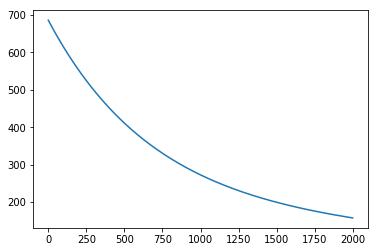

In [35]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights,1)
        self.w[5] = -100.
        self.w[9] = -100.
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, graident_w5, gradient_w9, eta=0.01):
        net.w[5] = net.w[5] - eta * gradient_w5
        net.w[9] = net.w[9] - eta * gradient_w9
        
    def train(self, x, y, iterations=100, eta=0.01):
        points = []
        losses = []
        for i in range(iterations):
            points.append([net.w[5][0], net.w[9][0]])
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            gradient_w5 = gradient_w[5][0]
            gradient_w9 = gradient_w[9][0]
            self.update(gradient_w5, gradient_w9, eta)
            losses.append(L)
            if i % 50 == 0:
                print('iter {}, point {}, loss {}'.format(i, [net.w[5][0], net.w[9][0]], L))
        return points, losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=2000
# 启动训练
points, losses = net.train(x, y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

### 对所有参数计算梯度并更新

为了能给读者直观的感受，上面演示的梯度下降法的过程仅包含$w_5$和$w_9$两个参数。房价预测的完整模型，必须要对所有参数$w$和$b$进行求解。这需要将Network中的update和train函数进行修改。由于不在限定参与计算的参数（所有参数均参与计算），修改之后的代码反而更加简洁。

iter 9, loss 1.8984947314576224
iter 19, loss 1.8031783384598725
iter 29, loss 1.7135517565541092
iter 39, loss 1.6292649416831264
iter 49, loss 1.5499895293373231
iter 59, loss 1.4754174896452612
iter 69, loss 1.4052598659324693
iter 79, loss 1.3392455915676864
iter 89, loss 1.2771203802372915
iter 99, loss 1.218645685090292
iter 109, loss 1.1635977224791534
iter 119, loss 1.111766556287068
iter 129, loss 1.0629552390811503
iter 139, loss 1.0169790065644477
iter 149, loss 0.9736645220185994
iter 159, loss 0.9328491676343147
iter 169, loss 0.8943803798194307
iter 179, loss 0.8581150257549611
iter 189, loss 0.8239188186389669
iter 199, loss 0.7916657692169988
iter 209, loss 0.761237671346902
iter 219, loss 0.7325236194855752
iter 229, loss 0.7054195561163928
iter 239, loss 0.6798278472589763
iter 249, loss 0.6556568843183528
iter 259, loss 0.6328207106387195
iter 269, loss 0.6112386712285092
iter 279, loss 0.59083508421862
iter 289, loss 0.5715389327049418
iter 299, loss 0.5532835757100

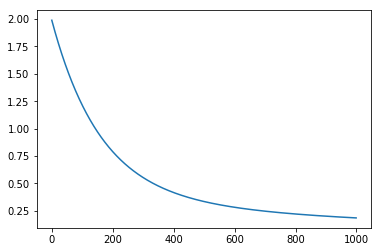

In [36]:
class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        gradient_w = (z-y)*x
        gradient_w = np.mean(gradient_w, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = (z - y)
        gradient_b = np.mean(gradient_b)        
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
        
    def train(self, x, y, iterations=100, eta=0.01):
        losses = []
        for i in range(iterations):
            z = self.forward(x)
            L = self.loss(z, y)
            gradient_w, gradient_b = self.gradient(x, y)
            self.update(gradient_w, gradient_b, eta)
            losses.append(L)
            if (i+1) % 10 == 0:
                print('iter {}, loss {}'.format(i, L))
        return losses

# 获取数据
train_data, test_data = load_data()
x = train_data[:, :-1]
y = train_data[:, -1:]
# 创建网络
net = Network(13)
num_iterations=1000
# 启动训练
losses = net.train(x,y, iterations=num_iterations, eta=0.01)

# 画出损失函数的变化趋势
plot_x = np.arange(num_iterations)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

### 小批量随机梯度下降法（Mini-batch Stochastic Gradient Descent）


在上述程序中，每次迭代的时候均基于数据集中的全部数据进行计算。但在实际问题中数据集往往非常大，如果每次计算都使用全部的数据来计算损失函数和梯度，效率非常低。一个合理的解决方案是每次从总的数据集中随机抽取出小部分数据来代表整体，基于这部分数据计算梯度和损失，然后更新参数。这种方法被称作小批量随机梯度下降法（Mini-batch Stochastic Gradient Descent），简称SGD。每次迭代时抽取出来的一批数据被称为一个min-batch，一个mini-batch所包含的样本数目称为batch_size。当程序迭代的时候，按mini-batch逐渐抽取出样本，当把整个数据集都遍历到了的时候，则完成了一轮的训练，也叫一个epoch。启动训练时，可以将训练的轮数num_epochs和batch_size作为参数传入。

下面结合程序介绍具体的实现过程。

In [37]:
# 获取数据
train_data, test_data = load_data()
train_data.shape

(404, 14)

train_data中一共包含404条数据，如果batch_size=10，即取前0-9号样本作为第一个mini-batch，命名train_data1。

In [38]:
train_data1 = train_data[0:10]
train_data1.shape

(10, 14)

使用train_data1的数据（0-9号样本）计算梯度并更新网络参数。

In [39]:
net = Network(13)
x = train_data1[:, :-1]
y = train_data1[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
loss

[0.9001866101467375]

再取出10-19号样本作为第二个mini-batch，计算梯度并更新网络参数。

In [40]:
train_data2 = train_data[10:19]
x = train_data1[:, :-1]
y = train_data1[:, -1:]
loss = net.train(x, y, iterations=1, eta=0.01)
loss

[0.8903272433979657]

按此方法不断的取出新的mini-batch并逐渐更新网络参数。
下面的程序可以将train_data分成大小为batch_size的多个mini_batch。

In [41]:
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]
print('total number of mini_batches is ', len(mini_batches))
print('first mini_batch shape ', mini_batches[0].shape)
print('last mini_batch shape ', mini_batches[-1].shape)

total number of mini_batches is  41
first mini_batch shape  (10, 14)
last mini_batch shape  (4, 14)


上面的代码将train_data分成 $\frac{404}{10} + 1 = 41$ 个 mini_batch了，其中前40个mini_batch，每个均含有10个样本，最后一个mini_batch只含有4个样本。

另外，我们这里是按顺序取出mini_batch的，而SGD里面是随机的抽取一部分样本代表总体。为了实现随机抽样的效果，我们先将train_data里面的样本顺序随机打乱，然后再抽取mini_batch。随机打乱样本顺序，需要用到np.random.shuffle函数，下面先介绍它的用法。

In [42]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
print('before shuffle', a)
np.random.shuffle(a)
print('after shuffle', a)

before shuffle [ 1  2  3  4  5  6  7  8  9 10 11 12]
after shuffle [ 7  2 11  3  8  6 12  1  4  5 10  9]


多次运行上面的代码，可以发现每次执行shuffle函数后的数字顺序均不同。
上面举的是一个1维数组乱序的案例，我们在观察下2维数组乱序后的效果。

In [43]:
# 新建一个array
a = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
a = a.reshape([6, 2])
print('before shuffle\n', a)
np.random.shuffle(a)
print('after shuffle\n', a)

before shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
after shuffle
 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 9 10]
 [11 12]
 [ 7  8]]


观察运行结果可发现，数组的元素在第0维被随机打乱，但第1维的顺序保持不变。例如数字2仍然紧挨在数字1的后面，数字8仍然紧挨在数字7的后面，而第二维的[3, 4]并不排在[1, 2]的后面。

综上随机乱序和抽取mini_batch的步骤，我们可以改写训练过程如下。每个随机抽取的mini-batch数据，输入到模型中用于参数训练。

In [44]:
# 获取数据
train_data, test_data = load_data()

# 打乱样本顺序
np.random.shuffle(train_data)

# 将train_data分成多个mini_batch
batch_size = 10
n = len(train_data)
mini_batches = [train_data[k:k+batch_size] for k in range(0, n, batch_size)]

# 创建网络
net = Network(13)

# 依次使用每个mini_batch的数据
for mini_batch in mini_batches:
    x = mini_batch[:, :-1]
    y = mini_batch[:, -1:]
    loss = net.train(x, y, iterations=1)

将这部分实现SGD算法的代码集成到Network类中的train函数中，最终的完整代码如下。

Epoch   0 / iter   0, loss = 0.6273
Epoch   0 / iter   1, loss = 0.4835
Epoch   0 / iter   2, loss = 0.5830
Epoch   0 / iter   3, loss = 0.5466
Epoch   0 / iter   4, loss = 0.2147
Epoch   1 / iter   0, loss = 0.6645
Epoch   1 / iter   1, loss = 0.4875
Epoch   1 / iter   2, loss = 0.4707
Epoch   1 / iter   3, loss = 0.4153
Epoch   1 / iter   4, loss = 0.1402
Epoch   2 / iter   0, loss = 0.5897
Epoch   2 / iter   1, loss = 0.4373
Epoch   2 / iter   2, loss = 0.4631
Epoch   2 / iter   3, loss = 0.3960
Epoch   2 / iter   4, loss = 0.2340
Epoch   3 / iter   0, loss = 0.4139
Epoch   3 / iter   1, loss = 0.5635
Epoch   3 / iter   2, loss = 0.3807
Epoch   3 / iter   3, loss = 0.3975
Epoch   3 / iter   4, loss = 0.1207
Epoch   4 / iter   0, loss = 0.3786
Epoch   4 / iter   1, loss = 0.4474
Epoch   4 / iter   2, loss = 0.4019
Epoch   4 / iter   3, loss = 0.4352
Epoch   4 / iter   4, loss = 0.0435
Epoch   5 / iter   0, loss = 0.4387
Epoch   5 / iter   1, loss = 0.3886
Epoch   5 / iter   2, loss =

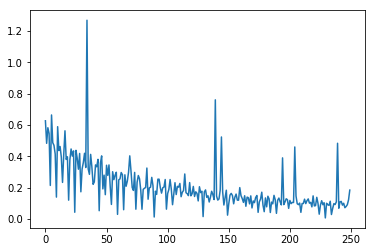

In [45]:
import numpy as np

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w = np.random.randn(num_of_weights, 1)
        self.b = 0.
        
    def forward(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y):
        z = self.forward(x)
        N = x.shape[0]
        gradient_w = 1. / N * np.sum((z-y) * x, axis=0)
        gradient_w = gradient_w[:, np.newaxis]
        gradient_b = 1. / N * np.sum(z-y)
        return gradient_w, gradient_b
    
    def update(self, gradient_w, gradient_b, eta = 0.01):
        self.w = self.w - eta * gradient_w
        self.b = self.b - eta * gradient_b
            
                
    def train(self, training_data, num_epoches, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epoches):
            # 在每轮迭代开始之前，将训练数据的顺序随机的打乱，
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a = self.forward(x)
                loss = self.loss(a, y)
                gradient_w, gradient_b = self.gradient(x, y)
                self.update(gradient_w, gradient_b, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

# 获取数据
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epoches=50, batch_size=100, eta=0.1)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

## 总结

本节，我们详细讲解了如何使用numpy实现梯度下降算法，构建并训练了一个简单的线性模型实现波士顿房价预测，可以总结出，使用神经网络建模房价预测有三个要点：

- 构建网络，初始化参数w和b，定义预测和损失函数的计算方法。

- 随机选择初始点，建立梯度的计算方法，和参数更新方式。

- 从总的数据集中抽取部分数据作为一个mini_batch，计算梯度并更新参数，不断迭代直到损失函数几乎不再下降。